## Install the package dependencies before running this notebook

In [43]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import torch.nn.functional as F
%matplotlib inline


"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

'\n    number of trajectories in each city\n    # austin --  train: 43041 test: 6325 \n    # miami -- train: 55029 test:7971\n    # pittsburgh -- train: 43544 test: 6361\n    # dearborn -- train: 24465 test: 3671\n    # washington-dc -- train: 25744 test: 3829\n    # palo-alto -- train:  11993 test:1686\n\n    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds\n    \n'

## Create a Torch.Dataset class for the training dataset

In [44]:
from glob import glob
import pickle
import numpy as np

ROOT_PATH = "./data/"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

def get_city_trajectories(city="palo-alto", split="train", standardized=False):

    
    outputs = None
    global_mean = 0
    global_std = 0
    
    if split=="train":
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        if standardized:
            inputs = np.asarray(inputs)
            global_mean = np.mean(inputs, axis = (0,1), keepdims = True)
            global_std = np.std(np.sqrt(inputs[:, :, 0]**2 + inputs[:, :, 0]**2))
        inputs = np.asarray(inputs)[:int(n * 0.6)]
        
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[:int(n * 0.6)]
        
    elif split == 'val':
        f_in = ROOT_PATH + 'train' + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        if standardized:
            inputs = np.asarray(inputs)
            global_mean = np.mean(inputs, axis = (0,1), keepdims = True)
            global_std = np.std(np.sqrt(inputs[:, :, 0]**2 + inputs[:, :, 0]**2))
        inputs = np.asarray(inputs)[int(n * 0.6):]
        
        f_out = ROOT_PATH + 'train' + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[int(n * 0.6):]
    
    else:
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        if standardized:
            inputs = np.asarray(inputs)
            global_mean = np.mean(inputs, axis = (0,1), keepdims = True)
            global_std = np.std(np.sqrt(inputs[:, :, 0]**2 + inputs[:, :, 0]**2))
        else:
            inputs = np.asarray(inputs)

    if standardized:
        standard_inputs = (inputs - global_mean)/global_std
        standard_targets = (outputs - global_mean)/global_std
        return standard_inputs, standard_targets
    return inputs, outputs

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, standardized:bool, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform
        self.standardized = standardized

        self.inputs, self.outputs = get_city_trajectories(city=city, split=split, standardized=self.standardized)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):

        data = (self.inputs[idx], self.outputs[idx])
            
        if self.transform:
            data = self.transform(data)

        return data

In [45]:
# intialize a dataset
def get_data_loader(city = 'austin', batch_size = 20, standardized=False):
    train_dataset  = ArgoverseDataset(city = city, split = 'train', standardized=standardized)
    val_dataset = ArgoverseDataset(city = city, split = 'val', standardized=standardized)

    train_loader = DataLoader(train_dataset,batch_size=batch_size)
    val_loader = DataLoader(val_dataset,batch_size=batch_size)
    return train_dataset, val_dataset, train_loader, val_loader

In [46]:
train_dataset, val_dataset, train_loader, val_loader = get_data_loader(city = 'austin', batch_size = 150, standardized=False)

In [47]:
len(val_dataset)

17217

In [48]:
len(train_dataset)

25824

## Create a DataLoader class for training

In [49]:
from torch import nn, optim

# model
class EncoderDecoder(nn.Module):

    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(100, 64),
            nn.LogSigmoid(),
            nn.Linear(64, 32),
            nn.LogSigmoid(),
            nn.Linear(32, 32)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.LogSigmoid(),
            nn.Linear(64, 120),
            nn.LogSigmoid(),
            nn.Linear(120, 120)
        )
        
    def forward(self, x):
        x = x.reshape(-1, 100).float()
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.reshape(-1, 60, 2)
        return x.float()

In [50]:
# model, optimizer, loss
model_encdoc = EncoderDecoder()
opt = optim.Adam(model_encdoc.parameters(), lr=1e-3)
loss_func = nn.MSELoss()

In [51]:
def train_epochs(model, train_loader, loss_func, opt, cuda, epochs = 10):

    if cuda:
        model.cuda()

    train_losses = []
    for epoch in range(epochs):

        total_loss = 0
        for i_batch, sample_batch in enumerate(train_loader):
            inp, out = sample_batch
            if cuda:
                inp, out = inp.cuda(), out.cuda()
            out = out.float()
            preds = model(inp.float())
            #loss = loss_func(preds, out) # MSE
            loss = torch.sqrt(loss_func(preds, out)) # RMSE

            opt.zero_grad()
            loss.backward()
            opt.step()

            total_loss += loss.item()

        print('epoch {} trian loss: {}'.format(epoch, total_loss / len(train_dataset)))
        train_losses.append(total_loss / len(train_dataset))
    return train_losses

In [52]:
def val_loss(model, val_loader, loss_func, opt):
    val_loss = 0
    for i_batch, sample_batch in enumerate(val_loader):
        inp, out = sample_batch
        out = out.float()
        preds = model(inp.float())
        #loss = loss_func(preds, out) # MSE
        loss = torch.sqrt(loss_func(preds, out)) # RMSE

        val_loss += loss.item()
    print('val loss: {}'.format(val_loss / len(val_dataset)))

In [53]:
def train_city(city, batch_size, standardized, epochs, cuda=False):
    # data loader
    train_dataset, val_dataset, train_loader, val_loader = get_data_loader(city = city, batch_size = batch_size, standardized=standardized)
    
    # model, optimizer, loss
    model_encdoc = EncoderDecoder()
    opt = optim.Adam(model_encdoc.parameters(), lr=1e-3)
    loss_func = nn.MSELoss()
    
    # train
    train_losses = train_epochs(model_encdoc, train_loader, loss_func, opt, epochs = epochs, cuda = cuda)
    
    # evaluate
    # val_loss(model_encdoc, val_loader, loss_func, opt)
    return model_encdoc, train_losses

In [54]:
model_austin, train_losses = train_city('austin', batch_size = 50, standardized = False, epochs = 30)

epoch 0 trian loss: 2.3362590036132227
epoch 1 trian loss: 0.8065985549781403
epoch 2 trian loss: 0.7548214597477494
epoch 3 trian loss: 0.7390577447458714
epoch 4 trian loss: 0.7070366890161601
epoch 5 trian loss: 0.7057912537304146
epoch 6 trian loss: 0.6643003741604688
epoch 7 trian loss: 0.6312198422507578
epoch 8 trian loss: 0.6269646749325106
epoch 9 trian loss: 0.658796870797097
epoch 10 trian loss: 0.5846778481570909
epoch 11 trian loss: 0.5679347066040228
epoch 12 trian loss: 0.5239692158636994
epoch 13 trian loss: 0.5124665482484423
epoch 14 trian loss: 0.5108827129468008
epoch 15 trian loss: 0.5386877960284255
epoch 16 trian loss: 0.49087399580369356
epoch 17 trian loss: 0.5018126094503769
epoch 18 trian loss: 0.47312354882705904
epoch 19 trian loss: 0.5016177665197569
epoch 20 trian loss: 0.4503959880442424
epoch 21 trian loss: 0.49337802441442175
epoch 22 trian loss: 0.4763341605884878
epoch 23 trian loss: 0.4513776455596182
epoch 24 trian loss: 0.43643724183463106
epoch 2

Text(0.5, 1.0, 'City--Austin')

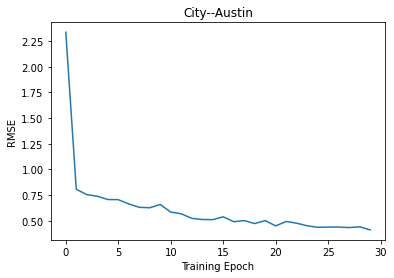

In [55]:
plt.plot(train_losses)
plt.xlabel('Training Epoch')
plt.ylabel('RMSE')
plt.title('City--Austin')

In [56]:
val_loss(model_austin, val_loader, loss_func, opt)

val loss: 0.22347534196526495


In [57]:
model_miami, train_losses = train_city('miami', batch_size = 50, epochs = 40, standardized=False)

epoch 0 trian loss: 5.989578288062354
epoch 1 trian loss: 1.368939937490513
epoch 2 trian loss: 1.3223189246255669
epoch 3 trian loss: 1.2822109417253562
epoch 4 trian loss: 1.2952383684993825
epoch 5 trian loss: 1.158723148714654
epoch 6 trian loss: 1.1665534672536224
epoch 7 trian loss: 1.327964003201311
epoch 8 trian loss: 1.162346998924364
epoch 9 trian loss: 1.161314204944554
epoch 10 trian loss: 1.1432388255735018
epoch 11 trian loss: 1.1471935724089433
epoch 12 trian loss: 1.1119238432898397
epoch 13 trian loss: 1.1210496628742384
epoch 14 trian loss: 1.1133410527360483
epoch 15 trian loss: 1.0775437731725133
epoch 16 trian loss: 1.064795990932682
epoch 17 trian loss: 1.0767373872512336
epoch 18 trian loss: 1.0255515497856424
epoch 19 trian loss: 1.0455101623558791
epoch 20 trian loss: 1.0265212304234652
epoch 21 trian loss: 1.0466757984704984
epoch 22 trian loss: 0.9687749730905488
epoch 23 trian loss: 0.9694400356604708
epoch 24 trian loss: 1.0084113670695374
epoch 25 trian lo

In [58]:
train_dataset, val_dataset, train_loader, val_loader = get_data_loader(city = 'miami', batch_size = 50, standardized=False)

In [59]:
val_loss(model_miami, val_loader, loss_func, opt)

val loss: 0.6682508029483696


In [60]:
model_pittsburgh, train_losses = train_city('pittsburgh', batch_size = 50, epochs = 40, standardized=False)

epoch 0 trian loss: 3.470706796084318
epoch 1 trian loss: 0.6670284564705148
epoch 2 trian loss: 0.6820946160879798
epoch 3 trian loss: 0.6461130693267388
epoch 4 trian loss: 0.624582048598629
epoch 5 trian loss: 0.6094535968938919
epoch 6 trian loss: 0.6549423513086949
epoch 7 trian loss: 0.6173941213090932
epoch 8 trian loss: 0.5866110293592319
epoch 9 trian loss: 0.609202762033814
epoch 10 trian loss: 0.5979114628020106
epoch 11 trian loss: 0.5881699145185048
epoch 12 trian loss: 0.6010319837186664
epoch 13 trian loss: 0.5582933865811848
epoch 14 trian loss: 0.5965676003670524
epoch 15 trian loss: 0.5580697766575615
epoch 16 trian loss: 0.5623181493248307
epoch 17 trian loss: 0.5666443516601023
epoch 18 trian loss: 0.5517705230546517
epoch 19 trian loss: 0.5561204270143535
epoch 20 trian loss: 0.5312604602333432
epoch 21 trian loss: 0.5403056349359918
epoch 22 trian loss: 0.5210717392996056
epoch 23 trian loss: 0.5398121217496067
epoch 24 trian loss: 0.5236193167071832
epoch 25 tria

In [61]:
train_dataset, val_dataset, train_loader, val_loader = get_data_loader(city = 'pittsburgh', batch_size = 50, standardized=False)
val_loss(model_pittsburgh, val_loader, loss_func, opt)

val loss: 0.6649036095383001


In [62]:
model_dearborn, train_losses = train_city('dearborn', batch_size = 50, epochs = 40, standardized=False)

epoch 0 trian loss: 7.603116695360542
epoch 1 trian loss: 1.1198250111253778
epoch 2 trian loss: 0.8851169684593413
epoch 3 trian loss: 0.8846074942196254
epoch 4 trian loss: 0.8995159522667419
epoch 5 trian loss: 0.8908748587285871
epoch 6 trian loss: 0.8263819120036673
epoch 7 trian loss: 0.8105446656995206
epoch 8 trian loss: 0.8643553264471616
epoch 9 trian loss: 0.8325387643269317
epoch 10 trian loss: 0.8270798374863155
epoch 11 trian loss: 0.8533699282696042
epoch 12 trian loss: 0.7795518565431613
epoch 13 trian loss: 0.8710878844247664
epoch 14 trian loss: 0.7636601621009741
epoch 15 trian loss: 0.795267515686965
epoch 16 trian loss: 0.8559014550268691
epoch 17 trian loss: 0.6856900798976033
epoch 18 trian loss: 0.8209548083762886
epoch 19 trian loss: 0.7826099591407405
epoch 20 trian loss: 0.7872246090526065
epoch 21 trian loss: 0.7909359627146729
epoch 22 trian loss: 0.7157021462438228
epoch 23 trian loss: 0.7607691218091365
epoch 24 trian loss: 0.824866663612962
epoch 25 tria

In [63]:
train_dataset, val_dataset, train_loader, val_loader = get_data_loader(city = 'dearborn', batch_size = 50, standardized=False)
val_loss(model_dearborn, val_loader, loss_func, opt)

val loss: 1.2910161773631745


In [64]:
model_washington_dc, train_losses = train_city('washington-dc', batch_size = 50, epochs = 40, standardized=False)

epoch 0 trian loss: 8.956621841689499
epoch 1 trian loss: 1.1382072351797294
epoch 2 trian loss: 1.0113867525752602
epoch 3 trian loss: 1.044848386009721
epoch 4 trian loss: 0.9409510441425427
epoch 5 trian loss: 0.9884725512596768
epoch 6 trian loss: 0.9364585251466756
epoch 7 trian loss: 0.8803112072388835
epoch 8 trian loss: 0.9525065035819682
epoch 9 trian loss: 0.9197975164928394
epoch 10 trian loss: 0.9389693413973585
epoch 11 trian loss: 0.9553013879602015
epoch 12 trian loss: 0.9087448906237443
epoch 13 trian loss: 0.9150483064945797
epoch 14 trian loss: 0.8845803356761869
epoch 15 trian loss: 0.8908147847622387
epoch 16 trian loss: 0.8771291960568054
epoch 17 trian loss: 0.9230593633193704
epoch 18 trian loss: 0.883744676461198
epoch 19 trian loss: 0.897702350612557
epoch 20 trian loss: 0.855932206351959
epoch 21 trian loss: 0.8805228622564382
epoch 22 trian loss: 0.8466919664385143
epoch 23 trian loss: 0.8984881729218492
epoch 24 trian loss: 0.8108983021989588
epoch 25 trian 

In [65]:
train_dataset, val_dataset, train_loader, val_loader = get_data_loader(city = 'washington-dc', batch_size = 50, standardized=False)
val_loss(model_washington_dc, val_loader, loss_func, opt)

val loss: 0.5450241042933758


In [66]:
model_palo_alto, train_losses = train_city('palo-alto', batch_size = 50, epochs = 40, standardized=False)

epoch 0 trian loss: 3.506883606891565
epoch 1 trian loss: 0.4808635620291054
epoch 2 trian loss: 0.4355807943416972
epoch 3 trian loss: 0.4262355370764193
epoch 4 trian loss: 0.4163259083660066
epoch 5 trian loss: 0.4110952520808855
epoch 6 trian loss: 0.40553235285303435
epoch 7 trian loss: 0.40389149327607227
epoch 8 trian loss: 0.40195549131751784
epoch 9 trian loss: 0.3940271378551356
epoch 10 trian loss: 0.3912963207777834
epoch 11 trian loss: 0.3893995096102197
epoch 12 trian loss: 0.38753039154937874
epoch 13 trian loss: 0.3834700510938072
epoch 14 trian loss: 0.37973846611883394
epoch 15 trian loss: 0.38189974069502725
epoch 16 trian loss: 0.3614388727299
epoch 17 trian loss: 0.3537062594700119
epoch 18 trian loss: 0.3579418643465873
epoch 19 trian loss: 0.37667635236397073
epoch 20 trian loss: 0.36377306452505054
epoch 21 trian loss: 0.33016273306392563
epoch 22 trian loss: 0.34764689539714627
epoch 23 trian loss: 0.34150232830983623
epoch 24 trian loss: 0.33243659257919667
ep

In [67]:
train_dataset, val_dataset, train_loader, val_loader = get_data_loader(city = 'palo-alto', batch_size = 50, standardized=False)
val_loss(model_palo_alto, val_loader, loss_func, opt)

val loss: 0.5048596702947772


## Make Prediction

In [68]:
cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
models = [model_austin, model_miami, model_pittsburgh, model_dearborn, model_washington_dc, model_palo_alto]

In [69]:
def predict_test(city, model):
    test_dataset = get_city_trajectories(city = city, split = 'test', standardized=False)[0]
    test_dataset = torch.from_numpy(test_dataset)
    pred = model(test_dataset).reshape(-1, 120)
    pred = pred.detach().numpy()
    return pd.DataFrame(pred)

In [70]:
columns =['ID'] + ['v'+str(i) for i in range(120)]

In [71]:
def predict_all(cities, models):
    out = predict_test(cities[0], models[0]).reset_index()
    out.columns = columns

    out['ID'] = out['ID'].astype(str) + '_' + cities[0]
    
    for city, model in zip(cities[1:], models[1:]):
        temp = predict_test(city, model).reset_index()
        temp.columns = columns
        temp['ID'] = temp['ID'].astype(str) + '_' + city
        out = pd.concat([out, temp])
    return out        

In [72]:
test_output = predict_all(cities, models)

In [73]:
test_output.to_csv('test_output.csv', index=False)

In [74]:
test_output

,ID,v0,v1,v2,v3,v4,v5,v6,v7,v8,...,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119
0,0_austin,-11.135794,-574.674805,-11.830410,-573.645569,-10.369962,-573.047363,-10.871705,-572.084595,-12.758583,...,-43.502983,-567.559448,-42.851494,-566.703857,-48.141739,-568.320740,-46.012909,-565.978149,-46.082886,-565.714844
1,1_austin,-340.915741,-12.704637,-345.077209,-17.245779,-341.792999,-15.793076,-340.936646,-12.157109,-346.860596,...,-335.443451,-27.586176,-341.613037,-24.649319,-342.612274,-35.538269,-339.013794,-28.149658,-338.829315,-27.302250
2,2_austin,52.975826,-250.983490,52.530811,-251.332123,53.171619,-250.740417,53.236786,-250.735489,52.957321,...,54.146084,-253.051270,53.710121,-253.031616,53.359547,-253.424164,53.844696,-253.158249,53.574944,-252.684204
3,3_austin,-109.058540,1834.362061,-113.189934,1825.817017,-111.755074,1836.504639,-115.403831,1834.945312,-117.187187,...,-153.663513,1819.274170,-165.886902,1825.918335,-159.291000,1821.685059,-164.091873,1834.348267,-159.513870,1822.441040
4,4_austin,1223.089478,-654.427307,1222.992310,-650.083130,1222.173950,-652.126160,1222.448486,-652.280518,1222.613525,...,1263.069946,-677.941223,1269.853149,-677.278076,1267.780273,-680.339661,1267.064941,-682.795837,1269.634521,-680.085693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1681,1681_palo-alto,-1407.804077,-491.250275,-1409.993530,-489.111267,-1409.609253,-491.096161,-1409.091431,-491.247528,-1409.375610,...,-1424.221802,-489.936890,-1422.272461,-490.678711,-1418.699097,-485.656677,-1424.343018,-491.329559,-1420.411987,-492.389008
1682,1682_palo-alto,122.908112,-23.078310,122.716385,-21.907106,122.893593,-22.249773,123.274139,-22.744703,123.480087,...,123.828476,-21.365889,122.891388,-20.867384,123.703781,-20.974857,123.624672,-20.527946,123.632347,-21.334909
1683,1683_palo-alto,-1437.933228,2153.345703,-1437.813965,2151.666992,-1440.338013,2152.989502,-1435.713623,2153.047607,-1439.136597,...,-1446.079224,2152.134277,-1448.326660,2149.573730,-1448.872559,2151.284668,-1445.403320,2153.050293,-1447.910889,2153.594482
1684,1684_palo-alto,1076.202271,1360.736206,1075.431030,1365.616943,1073.676636,1361.167114,1077.330933,1357.670166,1074.478394,...,1077.409912,1360.169312,1074.965942,1354.676147,1078.713623,1357.906006,1081.995361,1360.871460,1073.157593,1358.858276


## Sample a batch of data and visualize 

In [79]:
train_dataset, val_dataset, train_loader, val_loader = get_data_loader(city = 'austin', batch_size = 5, standardized=False)

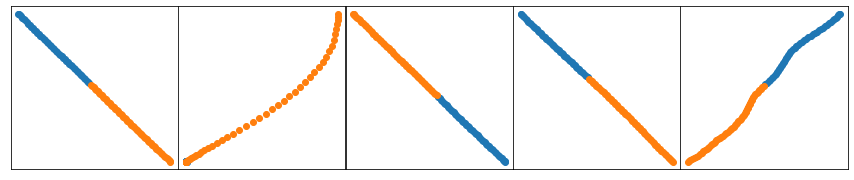

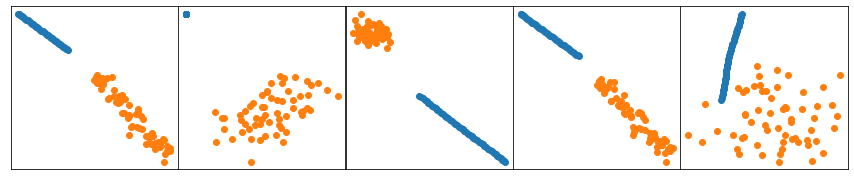

In [80]:
import matplotlib.pyplot as plt
import random


def show_sample_batch(sample_batch):
    """visualize the trajectory for a batch of samples"""
    inp, out = sample_batch
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)
    
    fig, axs = plt.subplots(1,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()   
    for i in range(batch_sz):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i,:,0], inp[i,:,1])
        axs[i].scatter(out[i,:,0], out[i,:,1])

        
for i_batch, sample_batch in enumerate(train_loader):
    if i_batch < 5: continue
    inp, out = sample_batch
    pred = model_austin(inp).detach()
    show_sample_batch(sample_batch)
    show_sample_batch([inp, pred])
    #print(sample_batch)
    break